In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime(2023,6,1)

data = yf.download(crypto_currency, start, end)

[*********************100%%**********************]  1 of 1 completed


In [2]:

price_scaler = MinMaxScaler(feature_range= (0,1))
scaled_price = price_scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_price)):
    x_train.append(scaled_price[x-prediction_days:x, 0])
    y_train.append(scaled_price[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Epoch 1/25
56/56 [==============================] - 4s 38ms/step - loss: 0.0110 - val_loss: 6.5850e-04
Epoch 2/25
56/56 [==============================] - 2s 30ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 3/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 7.5361e-04
Epoch 4/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0027 - val_loss: 4.1376e-04
Epoch 6/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 7/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0027 - val_loss: 4.0599e-04
Epoch 9/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0022 - val_loss: 3.1676e-04
Epoch 10/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0023 - val_lo

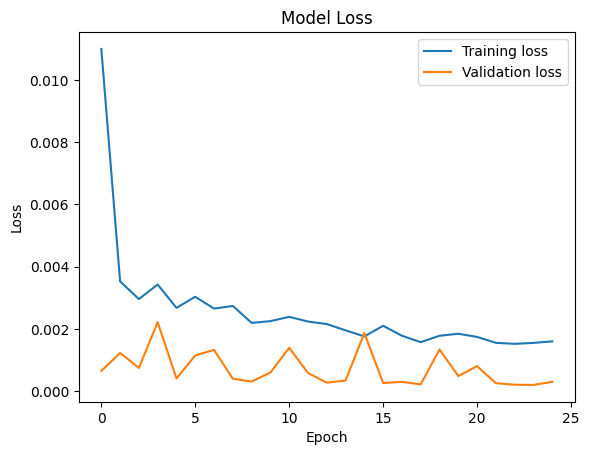

In [3]:
import keras
from keras import layers
model = keras.Sequential()
model.add(layers.LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))



model.compile(optimizer= 'adam', loss = 'mean_squared_error')

history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


394
11/11 [==============================] - 0s 7ms/step


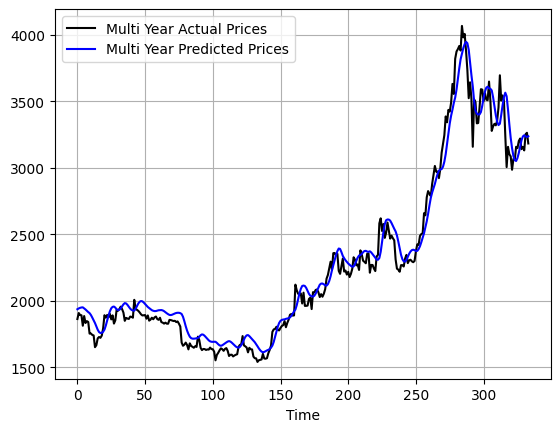

avg distance from actual price [86.05517]
Correct, Wrong and ratio if predicting price is up every day 171 162 0.5135135135135135
overall correct: 161 overall wrong: 172
longest overall correct streak: 6 longest overall wrong streak: 6
explained variance score: 0.9744645839703092
prediction window: 60


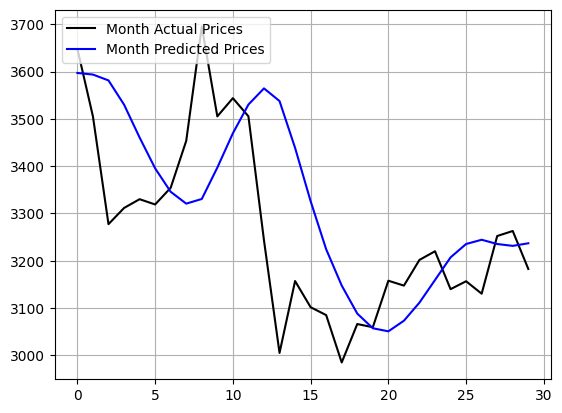

correct: 14 wrong: 15
longest correct streak: 2 longest wrong streak: 3



In [4]:

test_start = dt.datetime(2023,6,1)
test_end = dt.datetime.now()
test_data = yf.download(crypto_currency, test_start, test_end)


actual_prices = test_data['Adj Close'].values
total_price_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)


model_inputs_price = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values
model_inputs_price = model_inputs_price.reshape(-1,1)
model_inputs_price = price_scaler.transform(model_inputs_price)

x_test = []
print(len(model_inputs_price))
for x in range(prediction_days, len(model_inputs_price)):
    x_test.append(model_inputs_price[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = price_scaler.inverse_transform(prediction_prices)

prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
baseline=0
base = []
for i in range(len(prediction_prices)):
    if i != 0:
        base.append(actual_prices[i - 1])
        avg += abs(prediction_prices[i] - actual_prices[i])
        if actual_prices[i] > actual_prices[i- 1]:
            baseline += abs(actual_prices[i-1]-actual_prices[i])
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
#print("baseline avg distance from actual price", baseline/len(prediction_prices))           
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)
print()



In [5]:
from sklearn.metrics import explained_variance_score
y_true = actual_prices[1:]
y_pred = base
explained_variance_score(y_true, y_pred)

0.9881646909548607